In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

from scipy.stats import kstest
from scipy.interpolate import interp1d

In [2]:
def load_fiberstats_by_tracer(tracer='ELG'):
    min_nobs = 50

    cat = Table(fitsio.read('/global/cfs/cdirs/desicollab/users/rongpu/redshift_qa/jura_data/{}.fits'.format(tracer.lower())))


    cat['EFFTIME_BGS'] = 0.1400 * cat['TSNR2_BGS']
    cat['EFFTIME_LRG'] = 12.15 * cat['TSNR2_LRG']

    # Remove FIBERSTATUS!=0 fibers
    mask = cat['COADD_FIBERSTATUS']==0
    print('FIBERSTATUS   ', np.sum(~mask), np.sum(mask), np.sum(~mask)/len(mask))
    cat = cat[mask]

    # Remove "no data" fibers
    mask = cat['ZWARN'] & 2**9==0
    print('No data   ', np.sum(~mask), np.sum(mask), np.sum(~mask)/len(mask))
    cat = cat[mask]

    # Require a minimum depth for the cat coadd
    if tracer=='BGS_ANY':
        min_depth = 160
        mask = cat['EFFTIME_BGS']>min_depth
    else:
        min_depth = 800.
        mask = cat['EFFTIME_LRG']>min_depth
    print('Min depth   ', np.sum(~mask), np.sum(mask), np.sum(~mask)/len(mask))
    cat = cat[mask]

    if tracer=='LRG':
        # Apply maskbits
        maskbits = [1, 8, 9, 11, 12, 13]
        mask = np.ones(len(cat), dtype=bool)
        for bit in maskbits:
            mask &= (cat['MASKBITS'] & 2**bit)==0
        print('MASKBITS  ', np.sum(~mask), np.sum(mask), np.sum(~mask)/len(mask))
        cat = cat[mask]
    elif tracer=='ELG':
        # Apply maskbits
        maskbits = [1, 11, 12, 13]
        mask = np.ones(len(cat), dtype=bool)
        for bit in maskbits:
            mask &= (cat['MASKBITS'] & 2**bit)==0
        print('MASKBITS  ', np.sum(~mask), np.sum(mask), np.sum(~mask)/len(mask))
        cat = cat[mask]
        
    
    fibers = list(set(cat['FIBER']))

    cat_fibers = {}

    for fiber in fibers:
        ii = cat['FIBER']==fiber
        cat_fibers[fiber] = cat[ii] 
    return cat_fibers

In [3]:
elg_cat_fibers = load_fiberstats_by_tracer(tracer='ELG')
lrg_cat_fibers = load_fiberstats_by_tracer(tracer='LRG')
qso_cat_fibers = load_fiberstats_by_tracer(tracer='QSO')
bgs_cat_fibers = load_fiberstats_by_tracer(tracer='BGS_ANY')

FIBERSTATUS    264198 15709044 0.016540036142944557
No data    0 15709044 0.0
Min depth    587803 15121241 0.037418126780980436
MASKBITS   613801 14507440 0.04059197257685398
FIBERSTATUS    113487 6146815 0.018128039190441612
No data    0 6146815 0.0
Min depth    245309 5901506 0.039908310238717125
MASKBITS   440588 5460918 0.07465687571951973
FIBERSTATUS    100029 5287743 0.018565930406854635
No data    0 5287743 0.0
Min depth    207773 5079970 0.03929332420278368
FIBERSTATUS    245744 13618308 0.01772526531204586
No data    0 13618308 0.0
Min depth    492687 13125621 0.036178282940876355


In [24]:
n_percentiles = 20

data_sets = [bgs_cat_fibers, lrg_cat_fibers, elg_cat_fibers, qso_cat_fibers]
labels = ['BGS', 'LRG', 'ELG', 'QSO']

all_percentiles = {}

for i, (data, label) in enumerate(zip(data_sets, labels)):
    percentiles = []
    for j in data.keys():
        percent = np.percentile(data[j]['Z'], q=np.linspace(0,100,n_percentiles))
        percentiles.append(percent)
    percentiles_array = np.array(percentiles)
   
    all_percentiles[label] = percentiles_array


In [28]:
def analyze_fiber_outliers(all_percentiles_array, threshold_factor=2.0, plot=True):
    """
    Analyze fiber outliers based on percentile data.

    Parameters:
    all_percentiles_array (np.array): Array of percentile data for each fiber.
                                      Shape: (n_fibers, n_percentiles)
    threshold_factor (float): Factor to multiply std deviation for outlier threshold.
    plot (bool): Whether to generate plots.

    Returns:
    dict: Dictionary containing analysis results and outlier information.
    """
    # Compute mean and standard deviation across all fibers
    mean_percentiles = np.mean(all_percentiles_array, axis=0)
    std_percentiles = np.std(all_percentiles_array, axis=0)

    # Compute normalized deviation score for each fiber
    def compute_deviation_score(fiber_percentiles):
        normalized_diff = (fiber_percentiles - mean_percentiles) / std_percentiles
        return np.sqrt(np.mean(normalized_diff**2))

    deviation_scores = np.array([compute_deviation_score(fiber) for fiber in all_percentiles_array])

    # Identify outliers
    deviation_mean = np.mean(deviation_scores)
    deviation_std = np.std(deviation_scores)
    outlier_threshold = deviation_mean + threshold_factor * deviation_std
    outliers = np.where(deviation_scores > outlier_threshold)[0]

    # Prepare results
    results = {
        "mean_percentiles": mean_percentiles,
        "std_percentiles": std_percentiles,
        "deviation_scores": deviation_scores,
        "outlier_threshold": outlier_threshold,
        "outliers": outliers,
        "n_outliers":len(outliers),
        "top_outliers": sorted(enumerate(deviation_scores), key=lambda x: x[1], reverse=True)[:10]
    }

    if plot:
        plot_results(all_percentiles_array, results)

    return results

def plot_results(all_percentiles_array, results):
    """
    Generate plots for the fiber outlier analysis.
    """
    plt.figure(figsize=(15, 10))

    # Plot 1: All percentile curves with mean and std
    plt.subplot(221)
    for percentiles in all_percentiles_array:
        plt.plot(percentiles, color='lightgray', alpha=0.1)
    plt.plot(results["mean_percentiles"], color='blue', linewidth=2, label='Mean')
    plt.plot(results["mean_percentiles"] + results["std_percentiles"], color='red', linestyle='--', label='+1 Std')
    plt.plot(results["mean_percentiles"] - results["std_percentiles"], color='red', linestyle='--', label='-1 Std')
    plt.title('Percentile Curves with Mean and Std')
    plt.xlabel('Percentile Index')
    plt.ylabel('Z Value')
    plt.legend()

    # Plot 2: Histogram of deviation scores
    plt.subplot(222)
    plt.hist(results["deviation_scores"], bins=50)
    plt.axvline(results["outlier_threshold"], color='red', linestyle='--', label='Outlier Threshold')
    plt.title('Histogram of Deviation Scores')
    plt.xlabel('Deviation Score')
    plt.ylabel('Count')
    plt.legend()

    # Plot 3: Scatter plot of deviation scores
    plt.subplot(223)
    plt.scatter(range(len(results["deviation_scores"])), results["deviation_scores"], alpha=0.5)
    plt.axhline(results["outlier_threshold"], color='red', linestyle='--', label='Outlier Threshold')
    plt.title('Deviation Scores for Each Fiber')
    plt.xlabel('Fiber Index')
    plt.ylabel('Deviation Score')
    plt.legend()

    # Plot 4: Percentile curves of outliers
    plt.subplot(224)
    for i in results["outliers"]:
        plt.plot(all_percentiles_array[i], color='red', alpha=0.5)
    plt.plot(results["mean_percentiles"], color='blue', linewidth=2, label='Mean')
    plt.title(f'Percentile Curves of Outliers (n={len(results["outliers"])})')
    plt.xlabel('Percentile Index')
    plt.ylabel('Z Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# results = analyze_fiber_outliers(all_percentiles_array, threshold_factor=2.0)

# Print summary
# print(f"Number of fibers: {len(all_percentiles_array)}")
# print(f"Number of outliers detected: {len(results['outliers'])}")
# print(f"Outlier threshold: {results['outlier_threshold']:.4f}")
# print("\nTop 10 outliers (index, score):")
# for idx, score in results['top_outliers']:
#     print(f"Fiber {idx}: {score:.4f}")

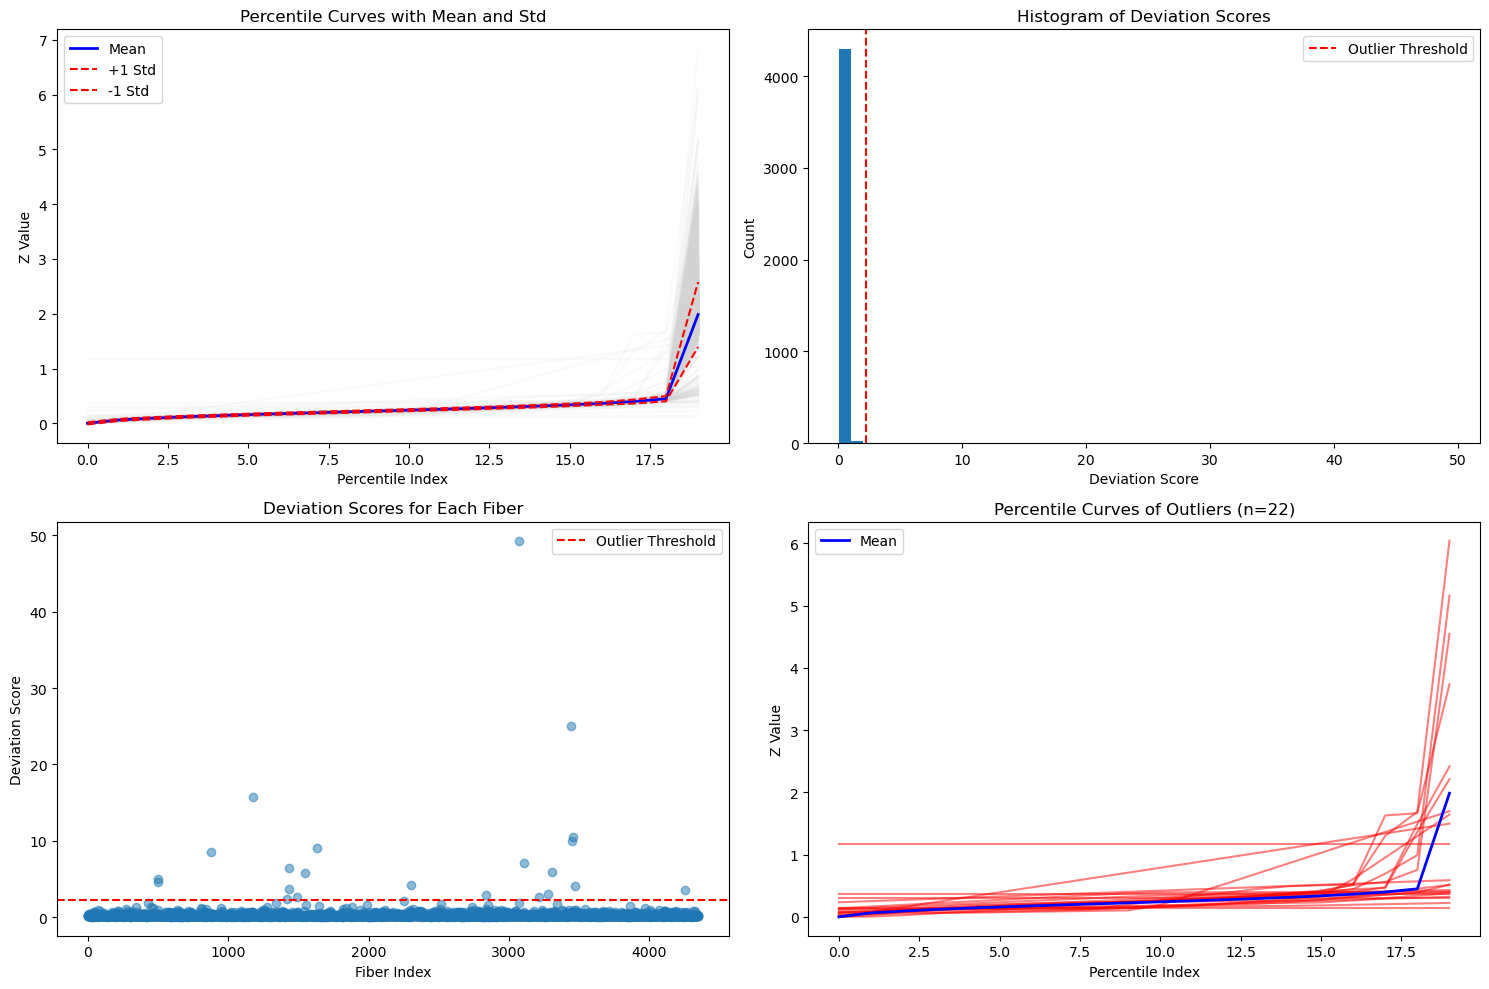

RESULTS FOR BGS\ {'mean_percentiles': array([-6.69304857e-05,  6.26736530e-02,  9.25107613e-02,  1.18271618e-01,
        1.38558007e-01,  1.57342626e-01,  1.75143849e-01,  1.91539513e-01,
        2.07533385e-01,  2.23774995e-01,  2.39850812e-01,  2.56669124e-01,
        2.73932604e-01,  2.92755781e-01,  3.13458046e-01,  3.36501981e-01,
        3.63258656e-01,  3.97458540e-01,  4.48807777e-01,  1.98515640e+00]), 'std_percentiles': array([0.02020922, 0.01869178, 0.01803415, 0.01753426, 0.0172717 ,
       0.01715534, 0.01713062, 0.01719188, 0.01737739, 0.01754807,
       0.01770947, 0.01807725, 0.0187259 , 0.0197193 , 0.0209242 ,
       0.02228002, 0.02420789, 0.03563667, 0.04658112, 0.59094265]), 'deviation_scores': array([0.33289673, 0.20683374, 0.19338024, ..., 0.18276779, 0.23603602,
       0.14981527]), 'outlier_threshold': 2.200341976789622, 'outliers': array([ 501,  502,  881, 1175, 1422, 1433, 1435, 1488, 1546, 1633, 2305,
       2834, 3070, 3107, 3212, 3277, 3306, 3439, 3451, 345

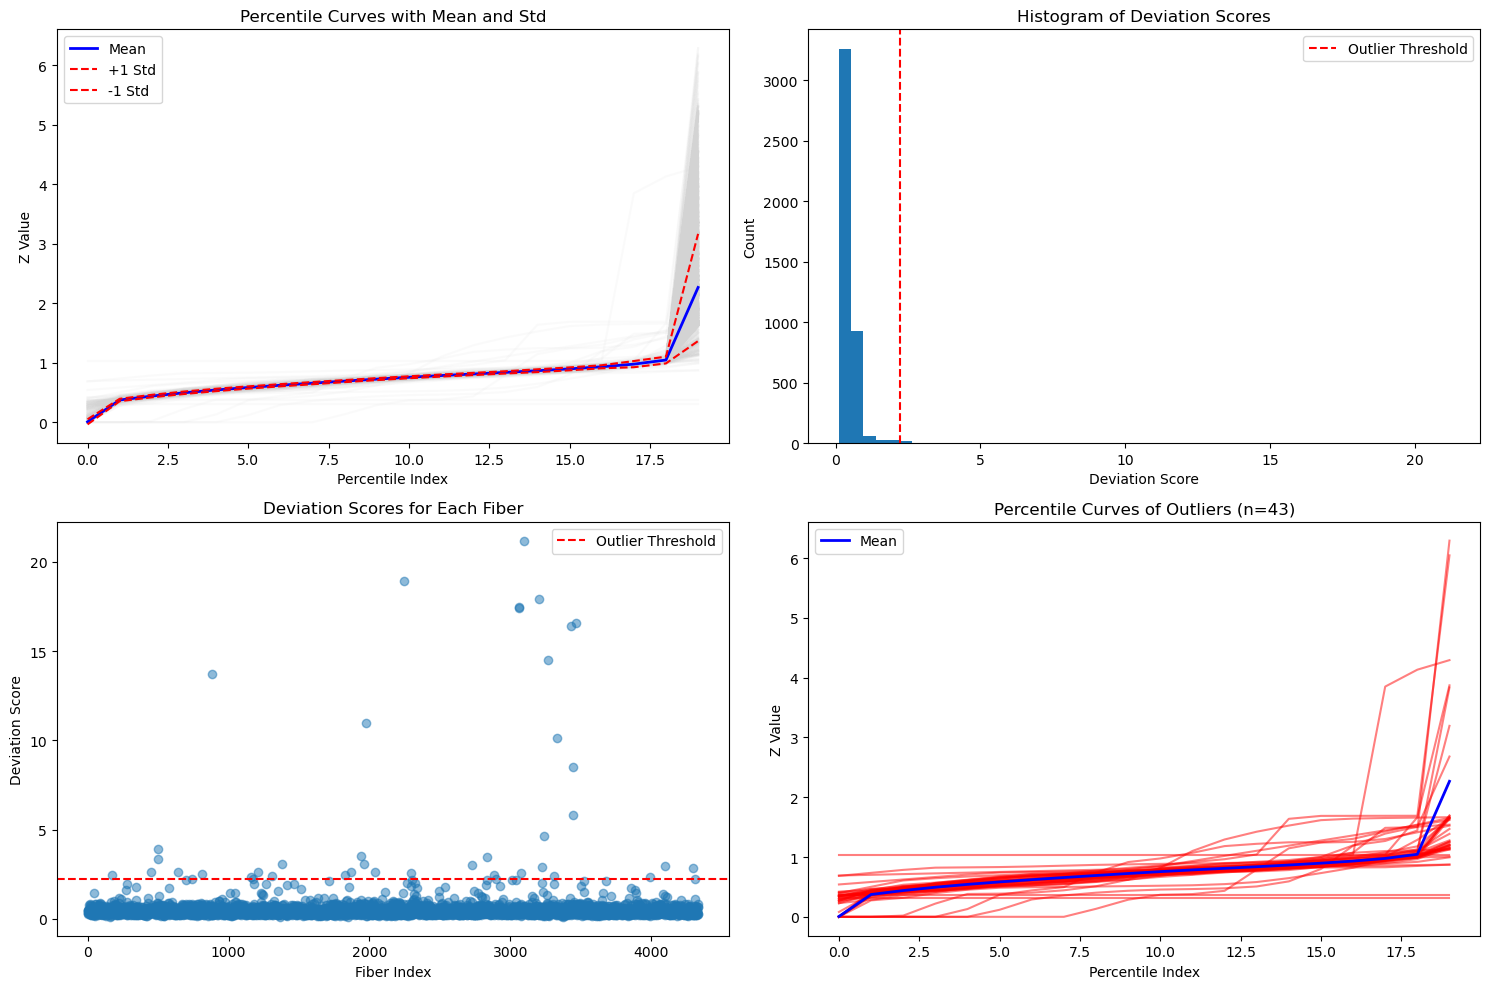

RESULTS FOR LRG\ {'mean_percentiles': array([0.00590881, 0.37319412, 0.43929227, 0.49471722, 0.54225832,
       0.58349041, 0.62118422, 0.65676027, 0.69113705, 0.72428519,
       0.75550365, 0.78430446, 0.81054889, 0.83750941, 0.86596184,
       0.89683817, 0.93210115, 0.97615579, 1.04555041, 2.26608282]), 'std_percentiles': array([0.04322954, 0.02028607, 0.02120755, 0.02107444, 0.02045033,
       0.01923832, 0.0186909 , 0.01884605, 0.0177138 , 0.01699036,
       0.01657491, 0.01754375, 0.01892328, 0.01928141, 0.02345685,
       0.02432898, 0.02537291, 0.05177258, 0.05680306, 0.90106085]), 'deviation_scores': array([0.49339193, 0.42176077, 0.47424619, ..., 0.26886483, 0.67471493,
       0.29993087]), 'outlier_threshold': 2.230916416020021, 'outliers': array([ 174,  449,  501,  502,  642,  744,  815,  881, 1162, 1174, 1210,
       1309, 1380, 1828, 1869, 1943, 1962, 1978, 2040, 2246, 2291, 2724,
       2836, 2884, 2895, 3058, 3061, 3072, 3095, 3200, 3223, 3235, 3265,
       3307, 3329, 

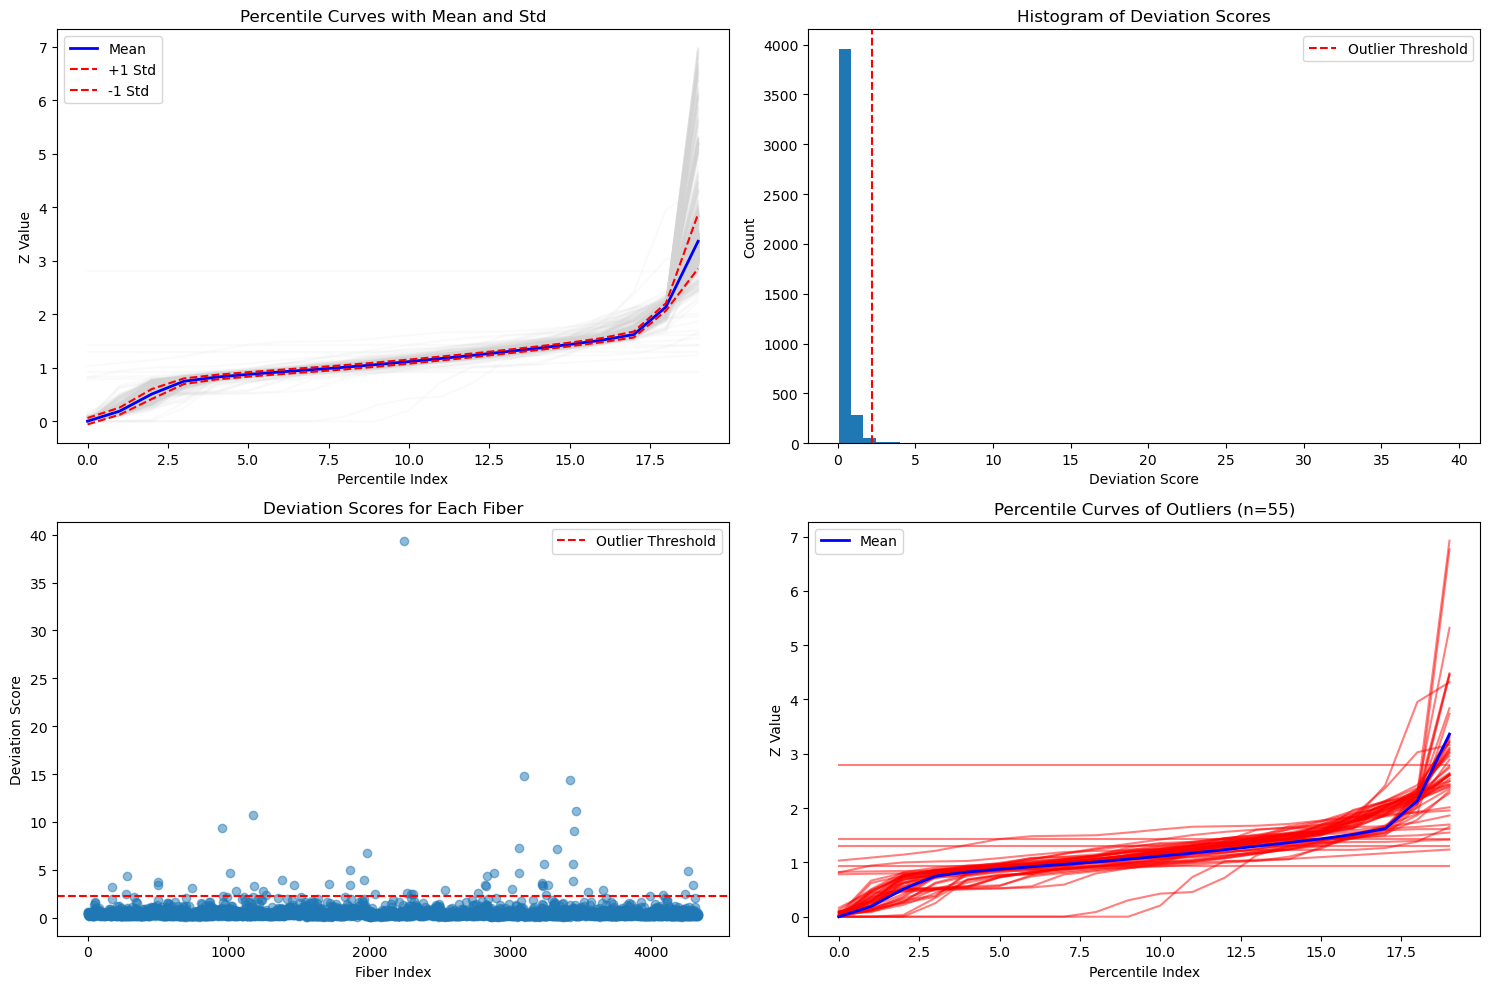

RESULTS FOR ELG\ {'mean_percentiles': array([6.34294554e-04, 1.88733635e-01, 5.08495114e-01, 7.47367908e-01,
       8.23174956e-01, 8.75301570e-01, 9.20935023e-01, 9.63835522e-01,
       1.00863994e+00, 1.05861794e+00, 1.11392928e+00, 1.17233578e+00,
       1.23279708e+00, 1.29733942e+00, 1.36332134e+00, 1.43454221e+00,
       1.51394065e+00, 1.62053015e+00, 2.13645628e+00, 3.36322827e+00]), 'std_percentiles': array([0.06017005, 0.06659858, 0.09319709, 0.05252998, 0.0433643 ,
       0.04188987, 0.04110817, 0.04042032, 0.04004748, 0.03991974,
       0.03866648, 0.03649216, 0.03498945, 0.03417068, 0.0339123 ,
       0.03404436, 0.03887864, 0.05507779, 0.06921688, 0.51080757]), 'deviation_scores': array([0.52599719, 0.39870821, 0.44506131, ..., 0.21202537, 0.29601433,
       0.37082583]), 'outlier_threshold': 2.2297304969322553, 'outliers': array([ 174,  274,  280,  501,  502,  744,  951,  962, 1010, 1050, 1175,
       1181, 1244, 1266, 1382, 1465, 1717, 1860, 1862, 1964, 1980, 2042,
    

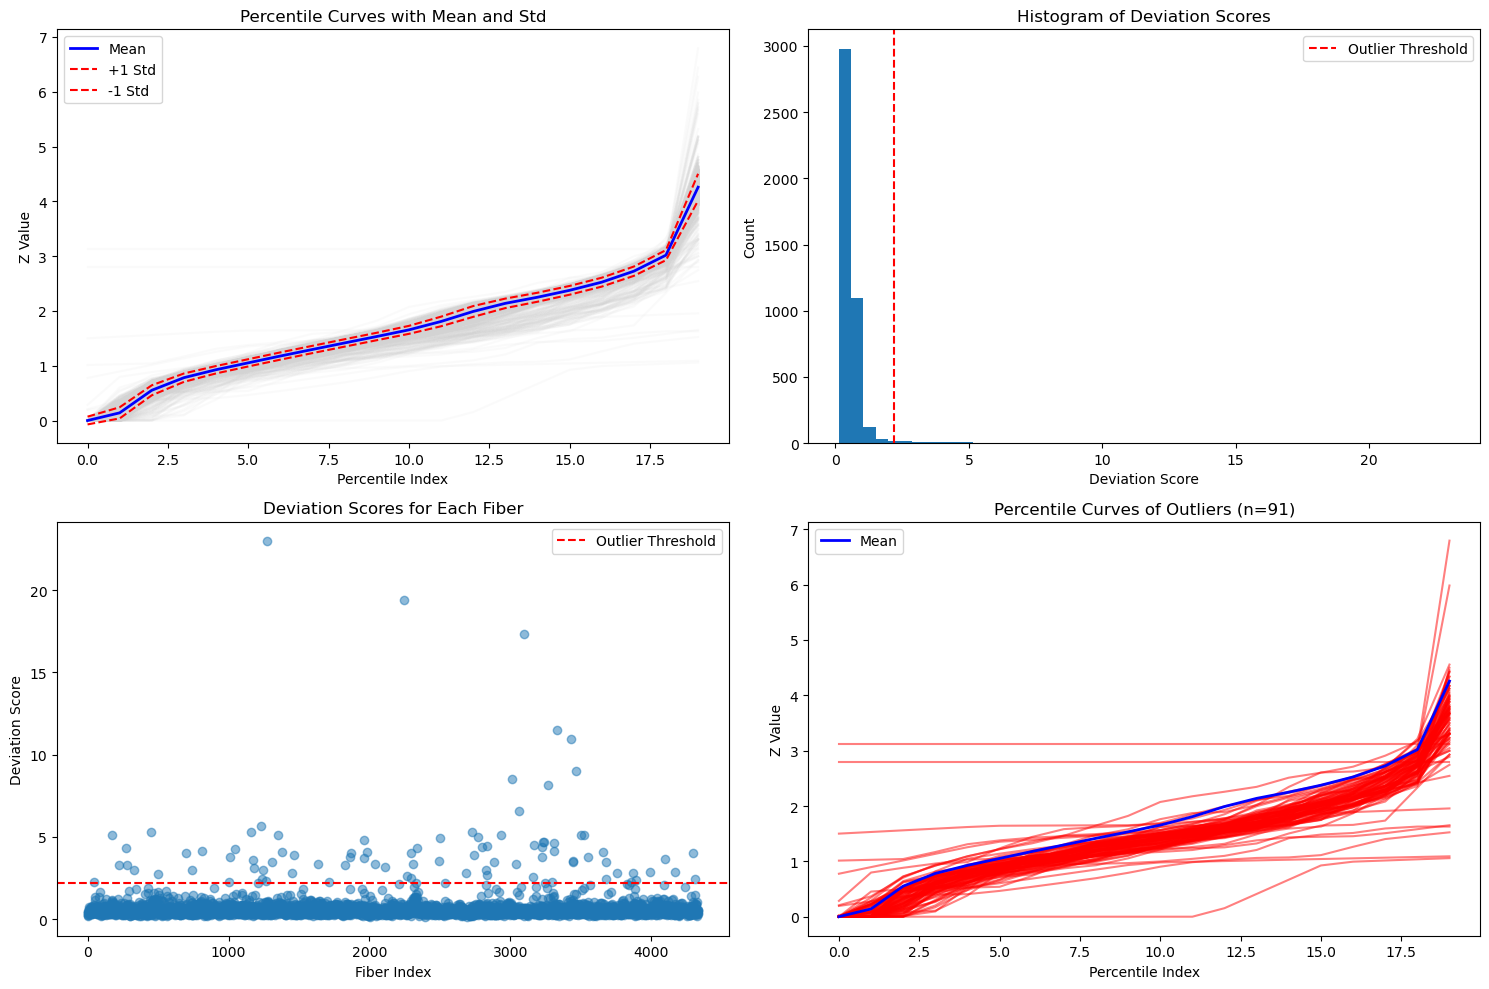

RESULTS FOR QSO\ {'mean_percentiles': array([3.52211389e-04, 1.40822897e-01, 5.52627620e-01, 7.82466038e-01,
       9.27731147e-01, 1.05294503e+00, 1.17733549e+00, 1.29713987e+00,
       1.41624578e+00, 1.53378466e+00, 1.65461750e+00, 1.80763587e+00,
       1.99044993e+00, 2.13837409e+00, 2.24969376e+00, 2.37585590e+00,
       2.52477842e+00, 2.72489368e+00, 3.01766597e+00, 4.25783971e+00]), 'std_percentiles': array([0.07074295, 0.10178101, 0.09128377, 0.07641884, 0.06771509,
       0.06608608, 0.06628159, 0.06646974, 0.06747673, 0.0680272 ,
       0.07274634, 0.08763446, 0.09849234, 0.08659328, 0.0820941 ,
       0.07983943, 0.08122625, 0.08498452, 0.09205927, 0.24436639]), 'deviation_scores': array([0.35321547, 0.48532223, 0.44247447, ..., 0.3898849 , 0.466516  ,
       0.5365341 ]), 'outlier_threshold': 2.1908925115597357, 'outliers': array([  49,  174,  226,  274,  280,  328,  449,  502,  701,  744,  815,
       1006, 1009, 1049, 1162, 1174, 1179, 1210, 1227, 1235, 1242, 1264,
    

In [30]:
labels = ['BGS', 'LRG', 'ELG', 'QSO']
for l in labels:
    outlier_results = analyze_fiber_outliers(all_percentiles[l])
    print('RESULTS FOR {}\n {}'.format(l,outlier_results))
    print('')

RESULTS FOR BGS
Number of outliers: 22
Outlier threshold: 2.2003
Top 5 outliers (index, score):
Fiber 3070: 49.2992
Fiber 3439: 25.0798
Fiber 1175: 15.7243
Fiber 3456: 10.5232
Fiber 3451: 9.9742

RESULTS FOR LRG
Number of outliers: 43
Outlier threshold: 2.2309
Top 5 outliers (index, score):
Fiber 3095: 21.1889
Fiber 2246: 18.9334
Fiber 3200: 17.9297
Fiber 3058: 17.4885
Fiber 3061: 17.4435

RESULTS FOR ELG
Number of outliers: 55
Outlier threshold: 2.2297
Top 5 outliers (index, score):
Fiber 2248: 39.3744
Fiber 3097: 14.8428
Fiber 3427: 14.3408
Fiber 3465: 11.1581
Fiber 1175: 10.7109

RESULTS FOR QSO
Number of outliers: 91
Outlier threshold: 2.1909
Top 5 outliers (index, score):
Fiber 1274: 23.0065
Fiber 2247: 19.4071
Fiber 3096: 17.3388
Fiber 3329: 11.4903
Fiber 3426: 10.9336

Common outliers across all labels:
Number of common outliers: 1

Common outlier details:
Fiber 502:
  BGS score: 5.0710
  LRG score: 3.3360
  ELG score: 3.3795
  QSO score: 2.7627



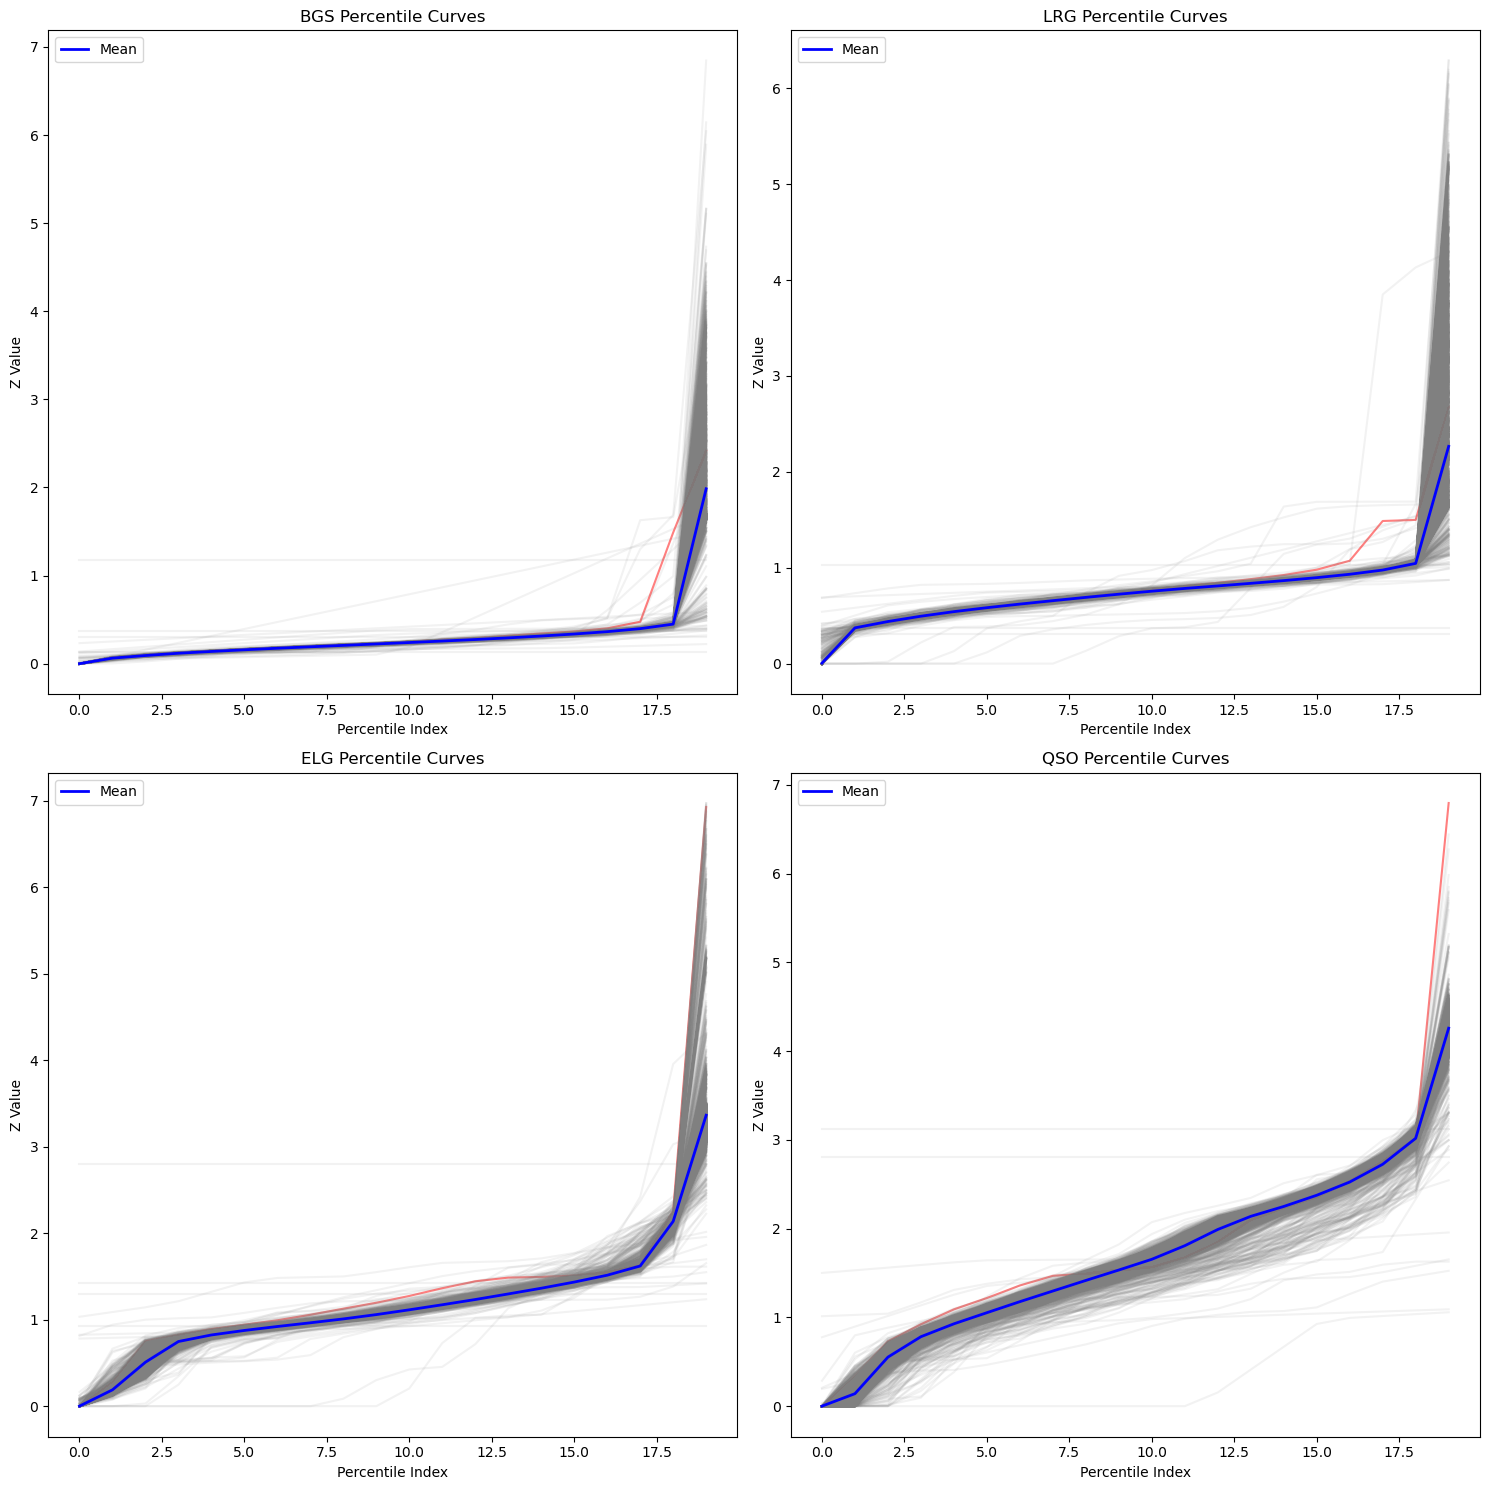

In [31]:
import numpy as np
from functools import reduce

def find_common_outliers(all_percentiles, labels):
    """
    Analyze outliers for each label and find common outliers across all labels.
    
    Parameters:
    all_percentiles (dict): Dictionary with labels as keys and percentile arrays as values
    labels (list): List of labels to analyze
    
    Returns:
    dict: Dictionary containing analysis results and common outliers
    """
    outlier_results = {}
    outlier_sets = {}
    
    for label in labels:
        outlier_results[label] = analyze_fiber_outliers(all_percentiles[label], plot=False)
        outlier_sets[label] = set(outlier_results[label]['outliers'])
        
        print(f'RESULTS FOR {label}')
        print(f"Number of outliers: {len(outlier_sets[label])}")
        print(f"Outlier threshold: {outlier_results[label]['outlier_threshold']:.4f}")
        print("Top 5 outliers (index, score):")
        for idx, score in outlier_results[label]['top_outliers'][:5]:
            print(f"Fiber {idx}: {score:.4f}")
        print('')
    
    # Find common outliers
    common_outliers = reduce(set.intersection, outlier_sets.values())
    
    # Get scores for common outliers
    common_outlier_scores = {label: {} for label in labels}
    for label in labels:
        for idx in common_outliers:
            common_outlier_scores[label][idx] = outlier_results[label]['deviation_scores'][idx]
    
    return {
        'outlier_results': outlier_results,
        'common_outliers': common_outliers,
        'common_outlier_scores': common_outlier_scores
    }

# Example usage
labels = ['BGS', 'LRG', 'ELG', 'QSO']
results = find_common_outliers(all_percentiles, labels)

print("Common outliers across all labels:")
print(f"Number of common outliers: {len(results['common_outliers'])}")
print("\nCommon outlier details:")
for idx in results['common_outliers']:
    print(f"Fiber {idx}:")
    for label in labels:
        print(f"  {label} score: {results['common_outlier_scores'][label][idx]:.4f}")
    print('')

# Optional: Visualize common outliers
import matplotlib.pyplot as plt

def plot_common_outliers(all_percentiles, labels, common_outliers):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    axs = axs.ravel()
    
    for i, label in enumerate(labels):
        for idx in range(len(all_percentiles[label])):
            if idx in common_outliers:
                axs[i].plot(all_percentiles[label][idx], color='red', alpha=0.5)
            else:
                axs[i].plot(all_percentiles[label][idx], color='gray', alpha=0.1)
        
        axs[i].plot(np.mean(all_percentiles[label], axis=0), color='blue', linewidth=2, label='Mean')
        axs[i].set_title(f'{label} Percentile Curves')
        axs[i].set_xlabel('Percentile Index')
        axs[i].set_ylabel('Z Value')
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

plot_common_outliers(all_percentiles, labels, results['common_outliers'])